## **Sign Language Recognition**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import json
import pickle

import os
import random
import matplotlib.pyplot as plt

### Required files:
- competition dataset:
    - *train_landmark_files*
    - *train.csv*
    - *sign_to_prediction_index_map.json*
 
- personal dataset:
    - *preprocess_dataset.pkl*
   
- personal data:
    - *cm_test.pt*
    - *class_report.csv*
- models:
    - *pointnet_transformer_model1_60.pth*


In [2]:
COMPETITION_PATH = '/kaggle/input/asl-signs/'
PROCESS_DATASET_PATH = "/kaggle/input/preprocess-dataset/preprocess_dataset.pkl"
dataset_path = '/kaggle/input/asl-signs/train_landmark_files'
user_ids = os.listdir('/kaggle/input/asl-signs/train_landmark_files')

# lips idx
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# left hand, by taking account face from 0 to 468
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])

REDUCED_LANDMARKS = np.sort(np.concatenate([LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, LEFT_POSE_IDXS0, RIGHT_POSE_IDXS0]))
# print(REDUCED_LANDMARKS)


# Opening JSON file
f = open('/kaggle/input/asl-signs/sign_to_prediction_index_map.json')

# opening train file
train_path = '/kaggle/input/asl-signs/train.csv'
train = pd.read_csv(train_path)

In [3]:
# returns JSON object as 
# a dictionary
WORD2IDX = json.load(f)
print(len(WORD2IDX), WORD2IDX)

WORD = list(WORD2IDX.keys())

250 {'TV': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, 'fall': 74, 'farm': 75, 'fast': 76, 'feet': 77, 'find': 7

In [4]:
train.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


## Useful functions

In [5]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [6]:
def select_random_sequence():
    usr = random.choice(user_ids)
    usr_sqc = os.listdir(os.path.join(dataset_path,usr))
    sqc = random.choice(usr_sqc)
    return os.path.join(dataset_path,usr,sqc)

In [7]:
def normalize_loaded_sequence(loaded_sqc):
    '''
        Function to normalize using min-max normalization. 
        Normalization is calculated over all points, but only relevants landmarks points are returned
        This function also replaces NaN by 0
    '''
    normalized_sqc = np.zeros((loaded_sqc.shape[0], len(REDUCED_LANDMARKS), 2))
    
    for frm_idx in range(loaded_sqc.shape[0]):
        frame_array = loaded_sqc[frm_idx]
        
        na_x = np.nan_to_num(frame_array[:,0], nan=0.0)
        na_y = np.nan_to_num(frame_array[:,1], nan=0.0)


        x_norm = (na_x-np.min(na_x))/(np.max(na_x)-np.min(na_x))
        y_norm = (na_y-np.min(na_y))/(np.max(na_y)-np.min(na_y))

        normalized_sqc[frm_idx,:,0],  normalized_sqc[frm_idx,:,1] = x_norm[REDUCED_LANDMARKS], y_norm[REDUCED_LANDMARKS]
    
    return normalized_sqc

In [8]:
def get_data(sqc_path):
    data = load_relevant_data_subset(sqc_path)
    data = normalize_loaded_sequence(data)
    return data

In [9]:
def get_word_from_key(key_index):
    position = list(WORD2IDX.values()).index(key_index)
    return WORD[position]

## Data analysis

In [10]:
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
pq_path = select_random_sequence()
df = pd.read_parquet(pq_path, columns=cols)
print(pq_path)
print(f'xmax: {np.max(df.x)}\nymax: {np.max(df.y)}\nxmin: {np.min(df.x)}\nymin: {np.min(df.y)}')

/kaggle/input/asl-signs/train_landmark_files/25571/504403950.parquet
xmax: 1.0951355695724487
ymax: 2.0877716541290283
xmin: 0.05947943776845932
ymin: 0.26811856031417847


### **Do not run next cell (takes time)**
or maybe run it one time for min values

In [11]:
# maxX=[]
# maxY=[]
# maxZ=[]
# for usr in user_ids:
#     usr_sqc = os.listdir(os.path.join(dataset_path,usr))
#     for sqc in usr_sqc:
#         pth = os.path.join(dataset_path,usr,sqc)
#         df = pd.read_parquet(pth, columns=['x', 'y', 'z'])
#         maxX.append(np.max(df.x))
#         maxY.append(np.max(df.y))
#         maxZ.append(np.max(df.z))

# print(f'max x: {np.max(maxX)}\nmax y: {np.max(maxY)}\nmax z: {np.max(maxZ)}')

'''
outputs:

max x: 2.9205052852630615
max y: 3.572496175765991
max z: 4.796591758728027
'''

'\noutputs:\n\nmax x: 2.9205052852630615\nmax y: 3.572496175765991\nmax z: 4.796591758728027\n'

### **Prepocessing**

In [12]:
def normalize_sequence(sequence_dataframe):
    '''
        function to normalize coordinates columns (x,y) per frame, also replace NaN values by column mean
        sequence_dataset is a pandas dataframe containing a sequence of an user
    '''



    frame_sqc_idx = sqc_df.frame.unique()
    normalized_df = pd.DataFrame()

    for frame in frame_sqc_idx:
        frame_df = sqc_df[sqc_df.frame == frame]
        frame_df1 = frame_df.copy()
        
        na_x = frame_df['x'].fillna(0.0)
        na_y = frame_df['y'].fillna(0.0)

        x_norm = (na_x-np.min(na_x))/(np.max(na_x)-np.min(na_x))
        y_norm = (na_y-np.min(na_y))/(np.max(na_y)-np.min(na_y))

        frame_df1.x, frame_df1.y = x_norm, y_norm
        normalized_df = pd.concat([normalized_df, frame_df1])
    
    return normalized_df

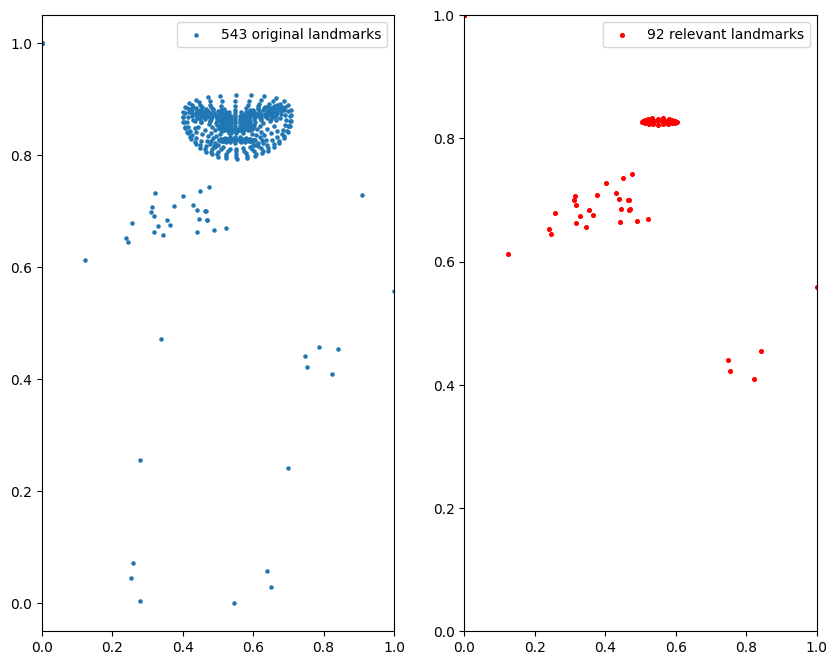

In [13]:
pq_path = select_random_sequence() # only first sequence of user here
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
sqc_df = pd.read_parquet(pq_path, columns=cols)

vv = get_data(pq_path)

n_df = normalize_sequence(sqc_df)
frame_df0 = n_df[n_df.frame == n_df.frame.unique()[0]]
frame_df1 = n_df[n_df.frame == n_df.frame.unique()[-1]]

X0 = frame_df0.x
Y0= frame_df0.y

X1 = frame_df1.x
Y1= frame_df1.y

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.xlim(0,1)
plt.scatter(X0,-Y0+1, s=5)
plt.legend(['543 original landmarks'])

plt.subplot(1,2,2)
# plt.scatter(X1,-Y1)
# plt.scatter(vv[-1,:,0],-vv[-1,:,1], s=3, c='r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(vv[0,:,0],-vv[0,:,1]+1, s=7, c='r')
plt.legend(['92 relevant landmarks'])


# plt.title(pq_path)
plt.show()

In [14]:
d=train.sign.value_counts(dropna=True)
print(f'mean number of sequence per sign: {d.mean()}')
print(f"standard deviation {d.std()}")
print(f"max number of sequence {d.max()}")
print(f"min number of sequence {d.min()}")

# word distribution is not too expended
# any words have close occurences

mean number of sequence per sign: 377.908
standard deviation 19.39536689593967
max number of sequence 415
min number of sequence 299


In [15]:
train.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [16]:
df = train[['participant_id', 'sequence_id']]
df.head()

,participant_id,sequence_id
0,26734,1000035562
1,28656,1000106739
2,16069,100015657
3,25571,1000210073
4,62590,1000240708


In [17]:
df_group = df.groupby(['participant_id'])['sequence_id'].size()
df_result = df_group.reset_index(name="nbr_of_sequences")

In [18]:
range(21)

range(0, 21)

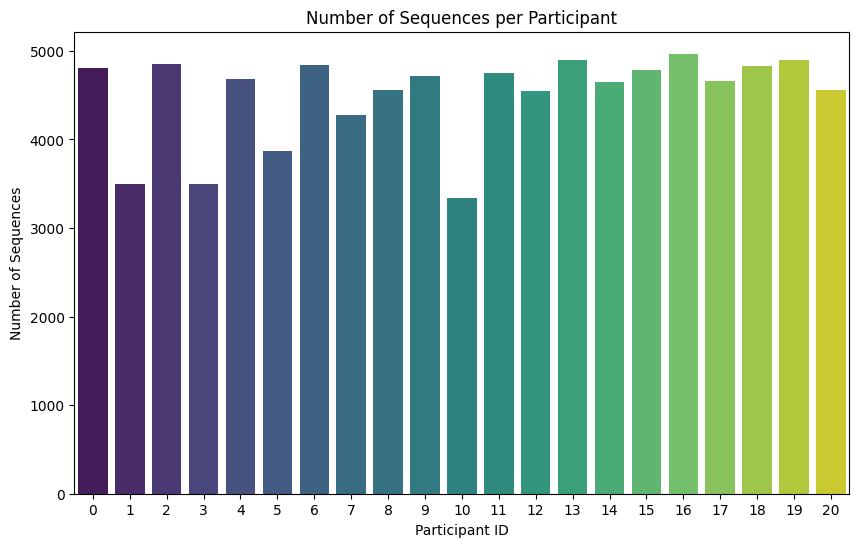

In [19]:
import seaborn as sns

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=np.array([i for i in range(21)]), y='nbr_of_sequences', data=df_result, palette='viridis')

# Add titles and labels
plt.title('Number of Sequences per Participant')
plt.xlabel('Participant ID')
plt.ylabel('Number of Sequences')

# Show the plot
plt.show()

In [20]:
df2 = train[['sign', 'sequence_id']]
df2.head()

,sign,sequence_id
0,blow,1000035562
1,wait,1000106739
2,cloud,100015657
3,bird,1000210073
4,owie,1000240708


In [21]:
df_group = df2.groupby(['sign'])['sequence_id'].size()
df_result = df_group.reset_index(name="nbr_of_sequences")

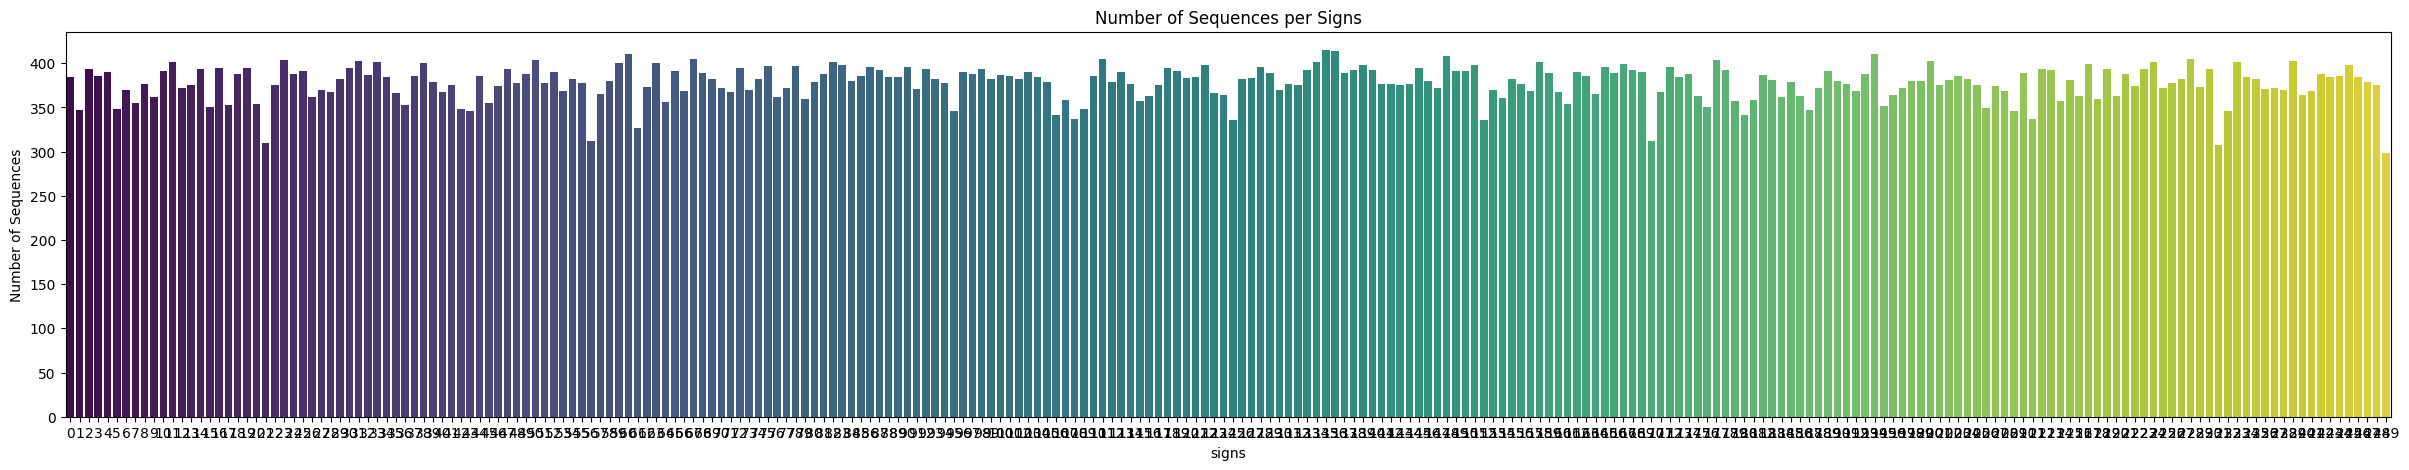

In [22]:
# Create a bar plot using Seaborn
plt.figure(figsize=(30, 5))
sns.barplot(x=np.array([i for i in range(250)]), y='nbr_of_sequences', data=df_result, palette='viridis')

# Add titles and labels
plt.title('Number of Sequences per Signs')
plt.xlabel('signs')
plt.ylabel('Number of Sequences')

# Show the plot
plt.show()

In [23]:
df2.sign.value_counts()

sign
listen    415
look      414
shhh      411
donkey    410
mouse     408
         ... 
dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: count, Length: 250, dtype: int64

## Pre process dataset 

### **Don't run following cell, it creates *preprocess_dataset***

In [24]:
def preprocess_dataset(train):
    processed_dataset = []
    for idx,path in enumerate(train.path):
        sequence_path = os.path.join(COMPETITION_PATH, path)
        word = train[train.path == path].sign.values[0]
        processed_sqc = get_data(sequence_path)

        processed_dataset.append((processed_sqc, word))
        
    
    return processed_dataset

In [25]:
# to save dataset
# with open("preprocess_dataset.pkl", "wb") as fp:   #Pickling
#     pickle.dump(processed_dataset, fp)

In [26]:
# to load dataset
with open(PROCESS_DATASET_PATH, "rb") as fp:   # Unpickling
    dataset = pickle.load(fp)

### **Custom class and Dataloader**

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [28]:
class ISLR(Dataset):
    def __init__(self, dataset, split):
        self.split = split
        self.dataset = dataset
        
        if split == 'trainval':
            self.islr_dataset = dataset[:int(0.8*len(dataset))]
        elif split =='test':
            self.islr_dataset = dataset[int(0.8*len(dataset)):]
        
    def __len__(self):
        return len(self.islr_dataset)
    
    def __getitem__(self, index):
        sample = self.islr_dataset[index]
        features = torch.FloatTensor(sample[0])
        target = WORD2IDX[sample[1]]
        
        return features, target

In [29]:
testset = ISLR(dataset, split='test')
trainvalset = ISLR(dataset, split='trainval')

In [30]:
trainset, valset = train_test_split(trainvalset,test_size=0.1, random_state=42)

In [31]:
def custom_collate_fn(batch):
    padded_batch = []
    labels= []

    max_frame = max(len(sequence) for sequence,_ in batch)
#     print(max_frame)
    for sequence, label in batch:
        padding_array = -np.ones(((max_frame-len(sequence)), len(REDUCED_LANDMARKS), 2))
        padded_sequence = sequence.tolist()+padding_array.tolist()

        padded_batch.append(padded_sequence)
        labels.append(label)


    return torch.tensor(padded_batch), torch.tensor(labels)

In [32]:
train_loader = DataLoader(trainset, 
                          batch_size=8, 
                          collate_fn=custom_collate_fn, 
                          shuffle=True,
                          num_workers=4)

In [33]:
val_loader = DataLoader(valset,
                        batch_size=8,
                        collate_fn=custom_collate_fn,
                        shuffle=False,
                        num_workers=4)

In [34]:
test_loader = DataLoader(testset,
                         batch_size=8,
                         collate_fn=custom_collate_fn,
                         shuffle=False,
                         num_workers=4)

In [35]:
custom_it = enumerate(train_loader)

In [36]:
idx,(sqc,lb)=next(custom_it)

## **Model architecture**

### Transformer

In [37]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, output_dim, n_landmarks, max_seq_length=1000):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim*n_landmarks, hidden_dim) # change encoding 
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.positional_encoding = self.create_positional_encoding(max_seq_length, hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        
        batch_size, n_frames, n_landmarks, input_dim = x.shape
        pad_mask = self.sequence_mask(x)
        pad_mask = pad_mask.to(device)
        
        # Flatten n_landmarks and input_dim for embedding
        x = x.view(batch_size, n_frames, -1)
        x = x.to(device)
        x = self.embedding(x)
        
        x = self.layer_norm1(x)
        x += self.positional_encoding[:, :n_frames, :].to(device)
        x = x.permute(1, 0, 2)  # Transformer expects sequence length first
                
        transformer_out = self.transformer_encoder(x,src_key_padding_mask=pad_mask)
        out = self.fc(transformer_out[-1, :, :])
        assert not torch.isnan(out).any(), "NaN in final output"
        
        return out
    
    def create_positional_encoding(self, max_seq_length, hidden_dim):
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / hidden_dim))
        
        positional_encoding = torch.zeros(max_seq_length, hidden_dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        
        return positional_encoding.unsqueeze(0)
    
    def sequence_mask(self, sequence):
        lengths = [self.valid_len(padded_sequence) for padded_sequence in sequence]
        
        mask = torch.zeros(sequence.size()[:2], dtype=torch.bool)  # shape: [batch_size, n_frames]
        for i, length in enumerate(lengths):
            mask[i, :length] = 1
        
        mask = ~mask # True values are ignored
        return mask

        
    def valid_len(self, padded_sequence):
        for idx, frame in  enumerate(padded_sequence):
            if -1 in frame:
                break

        return idx+1

In [38]:
input_dim = 2  # (x, y)
num_heads = 4
num_layers = 2
hidden_dim = 64
output_dim = 250  # number of classes
n_landmarks = 92


model1 = TransformerModel(input_dim=input_dim,
                         num_heads=num_heads,
                         num_layers=num_layers,
                         hidden_dim=hidden_dim,
                         output_dim=output_dim,
                         n_landmarks=n_landmarks)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1 = model1.to(device)
print(model1)

TransformerModel(
  (embedding): Linear(in_features=184, out_features=64, bias=True)
  (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=250, bias=True)
)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [39]:
model1(sqc)

tensor([[ 0.2612,  0.1592, -0.4816,  ..., -0.6208, -0.4169,  0.9764],
        [ 0.3504,  0.3664, -0.1558,  ..., -0.1052, -0.4321,  1.1036],
        [ 0.3027,  0.3561,  0.0777,  ..., -0.1958, -0.6545,  0.8263],
        ...,
        [ 0.2672,  0.2032,  0.0893,  ...,  0.1331, -0.6327,  1.2763],
        [ 0.3919,  0.2070, -0.3691,  ..., -0.5556, -0.5756,  0.7526],
        [ 0.4517,  0.2955, -0.1063,  ..., -0.0223, -0.5781,  1.1260]],
       grad_fn=<AddmmBackward0>)

In [40]:
# smaller model, model2

num_heads = 2
num_layers = 1
hidden_dim = 32


model2 = TransformerModel(input_dim=input_dim,
                         num_heads=num_heads,
                         num_layers=num_layers,
                         hidden_dim=hidden_dim,
                         output_dim=output_dim,
                         n_landmarks=n_landmarks)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model2 = model2.to(device)
print(model2)

TransformerModel(
  (embedding): Linear(in_features=184, out_features=32, bias=True)
  (layer_norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=250, bias=True)
)


### **Training Phase**

### Train several models to compare

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [42]:
MODEL1_PATH = "/kaggle/input/islr_transformer_model1_30epochs/pytorch/model1_45ep/1/pointnet_transformer_model1_45.pth"
MODEL2_PATH = "/kaggle/input/islr_transformer_model2/pytorch/model2_45ep/1/pointnet_transformer_model2_45.pth"

In [43]:
input_dim = 2  # (x, y)
num_heads = 4
num_layers = 2
hidden_dim = 64
output_dim = 250
n_landmarks = 92

model1 = TransformerModel(input_dim=input_dim,
                         num_heads=num_heads,
                         num_layers=num_layers,
                         hidden_dim=hidden_dim,
                         output_dim=output_dim,
                         n_landmarks=n_landmarks)

if  torch.cuda.is_available():
    model1.load_state_dict(torch.load(MODEL1_PATH))
else:
    model1.load_state_dict(torch.load(MODEL1_PATH, map_location=torch.device('cpu')))


In [44]:
input_dim = 2  # (x, y)
num_heads = 2
num_layers = 1
hidden_dim = 32
output_dim = 250
n_landmarks = 92

model2 = TransformerModel(input_dim=input_dim,
                         num_heads=num_heads,
                         num_layers=num_layers,
                         hidden_dim=hidden_dim,
                         output_dim=output_dim,
                         n_landmarks=n_landmarks)

if torch.cuda.is_available():
    model2.load_state_dict(torch.load(MODEL2_PATH))
else:
    model2.load_state_dict(torch.load(MODEL2_PATH, map_location=torch.device('cpu')))

In [45]:
model1.to(device)
model2.to(device)

TransformerModel(
  (embedding): Linear(in_features=184, out_features=32, bias=True)
  (layer_norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=250, bias=True)
)

In [46]:
o1 = model1(sqc)
o2 = model2(sqc)

In [47]:
loss_function = nn.CrossEntropyLoss()
optim1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
optim2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

In [48]:
# num_epochs = 15

# dataloader = train_loader

# for epoch in range(num_epochs):

#     print(f'Epoch {epoch+1}/{num_epochs}')
#     print('-' * 10)
    
#     model1.train()
#     model2.train()
    
#     running_l1 = 0.0
#     running_l2 = 0.0

#     for sequence, label in dataloader:
#         sequence, label = sequence.to(device), label.to(device)
        
#         optim1.zero_grad()
#         optim2.zero_grad()


#         target = label
        
#         out1 = model1(sequence)
#         out2 = model2(sequence)


#         # Compute the loss, gradients, and update optimizer
#         loss1 = loss_function(out1, target)
#         loss2 = loss_function(out2, target)

#         loss1.backward()
#         loss2.backward()
        
#         optim1.step()
#         optim2.step()

    
#         running_l1 += loss1.item()
#         running_l2 += loss2.item()
        


#     epoch_l1 = running_l1 / len(dataloader)
#     epoch_l2 = running_l2 / len(dataloader)

#     print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_l1:.4f}")
#     print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_l2:.4f}")

    
#     # Validation step
#     model1.eval()
#     model2.eval()

#     val_loss1 = 0.0
#     correct_top5_mod1 = 0
#     correct_mod1 = 0
    
#     val_loss2 = 0.0
#     correct_top5_mod2 = 0
#     correct_mod2= 0
    
#     total = 0
    
#     with torch.no_grad():
#         for sequence, label in val_loader:
#             sequence, label = sequence.to(device), label.to(device)
            
#             out1 = model1(sequence)
#             out2 = model2(sequence)

#             loss1 = loss_function(out1, label)
#             loss2 = loss_function(out2, label)

#             val_loss1 += loss1.item() * sequence.size(0)
#             val_loss2 += loss2.item() * sequence.size(0)

            
# #           use top 5 pred
#             _, pred1_top5 = torch.topk(out1, 5, dim=1)
#             _, pred2_top5 = torch.topk(out2, 5, dim=1)

#             correct_top5_mod1 += (pred1_top5.to(device) == label.view(-1, 1)).sum().item()
#             correct_top5_mod2 += (pred2_top5.to(device) == label.view(-1, 1)).sum().item()

# #             top prediction
#             _, pred1 = torch.max(out1, 1)
#             _, pred2 = torch.max(out2, 1)

#             correct_mod1 += (pred1 == label).sum().item()
#             correct_mod2 += (pred2 == label).sum().item()
            
            
#             total += label.size(0)



#     val_loss1 /= len(val_loader.dataset)
#     val_loss2 /= len(val_loader.dataset)
    
#     val_acc1 = correct_mod1 /total
#     val_acc2 = correct_mod2 /total

#     val_acc1_top5 = correct_top5_mod1/total
#     val_acc2_top5 = correct_top5_mod2/total

#     print(f'(model1) val loss: {val_loss1:.4f} Acc: {val_acc1:.4f} Top 5 Acc: {val_acc1_top5:.4f}')
#     print(f'(model2) val loss: {val_loss2:.4f} Acc: {val_acc2:.4f} Top 5 Acc: {val_acc2_top5:.4f}')


#     torch.save(model1.state_dict(), f'pointnet_transformer_model1_{epoch+1}.pth')
#     torch.save(model2.state_dict(), f'pointnet_transformer_model2_{epoch+1}.pth')

### Load model and analyze

In [49]:
MODEL1_PATH = "/kaggle/input/islr_transformer_model1_30epochs/pytorch/model1_60ep/1/pointnet_transformer_model1_60.pth"
MODEL2_PATH = "/kaggle/input/islr_transformer_model2/pytorch/model2_45ep/1/pointnet_transformer_model2_45.pth"

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [51]:
input_dim = 2  # (x, y)
num_heads = 4
num_layers = 2
hidden_dim = 64
output_dim = 250
n_landmarks = 92

model_load = TransformerModel(input_dim=input_dim,
                         num_heads=num_heads,
                         num_layers=num_layers,
                         hidden_dim=hidden_dim,
                         output_dim=output_dim,
                         n_landmarks=n_landmarks)

if torch.cuda.is_available():
    model_load.load_state_dict(torch.load(MODEL1_PATH))
else:
    model_load.load_state_dict(torch.load(MODEL1_PATH, map_location=torch.device('cpu')))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [52]:
model_load.to(device)

TransformerModel(
  (embedding): Linear(in_features=184, out_features=64, bias=True)
  (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=250, bias=True)
)

In [53]:
correct = 0
total = 0
model_load.eval()
true_labels = []
predicted_labels = []

confusion_matrix = torch.zeros(250, 250)

with torch.no_grad():
      for i, (sequence, label) in enumerate(test_loader):
            sequence, label = sequence.to(device), label.to(device)
            
            outputs = model_load(sequence)

            _, pred = torch.max(outputs, 1)
            correct += (pred == label).sum().item()
            
            true_labels = true_labels+label.tolist()
            predicted_labels = predicted_labels+pred.tolist()

            total += label.size(0)
            
            for t, p in zip(label.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

#             if i%200==0:
#                 print(f'Ground Truth: {label}')
#                 print(f'Prediction: {pred}')
#                 print('-'*10)

print(f'Accuracy of the network on the test set: {100 * correct // total} %')

Accuracy of the network on the test set: 66 %


In [54]:
if "cm_test.pt" in os.listdir("/kaggle/input/confusion-matrix/"):
    confusion_matrix = torch.load("/kaggle/input/confusion-matrix/cm_test.pt")
else:
    torch.save(confusion_matrix, "cm_test.pt")

In [55]:
import pandas as pd

if "class_report.csv" in os.listdir("/kaggle/input/class-report"):
    print('loading class_report.csv...')
    class_report_df = pd.read_csv("/kaggle/input/class-report/class_report.csv")
    print('class_report loaded')
    
else: 
    print('create classification report')
    report = classification_report(true_labels, predicted_labels, output_dict=True)
    # Convert the report dictionary to a pandas DataFrame
    report_df = pd.DataFrame(report).transpose()
    class_report_df = report_df.drop(['accuracy','macro avg', 'weighted avg'])
    class_report_df.to_csv("/kaggle/working/class_report.csv", header=True, index=False)
    print('saved to /kaggle/working/class_report.csv')

loading class_report.csv...
class_report loaded


In [56]:
f1_score=class_report_df['f1-score']
support = class_report_df['support']

In [57]:
value_to_keep = 5
sorted_classes=np.argsort(f1_score.values)
worst_classes = sorted_classes[:value_to_keep]
best_classes = sorted_classes[-value_to_keep:]

In [58]:
best_classes

array([219,  63, 165,  86,  49])

In [59]:
worst_classes

array([ 95, 216,  21,  80, 231])

In [60]:
for class_idx in worst_classes:
    print(get_word_from_key(class_idx))

give
there
beside
finger
vacuum


In [61]:
for class_idx in best_classes:
    print(get_word_from_key(class_idx))

tiger
drink
owl
flower
clown


In [62]:
def mean_len_word_sqcs(class_index):
    word = get_word_from_key(class_index)
    worst_class_path = train[train.sign == word].path.values
    sequence_length = []
    for idx,sqc_path in enumerate(worst_class_path):
        sequence = get_data(os.path.join(COMPETITION_PATH,sqc_path))
        sequence_length.append(len(sequence))


    return np.mean(sequence_length), np.std(sequence_length)

In [63]:
for class_idx in best_classes:
    print(f'{get_word_from_key(class_idx)} : {mean_len_word_sqcs(class_idx)}')

tiger : (42.078680203045685, 45.94044259994064)
drink : (38.9525, 43.78093470621659)
owl : (41.38383838383838, 40.55927376441931)
flower : (44.99242424242424, 46.11407071996001)
clown : (38.20360824742268, 36.72252163493097)


In [64]:
for class_idx in worst_classes:
    print(f'{get_word_from_key(class_idx)} : {mean_len_word_sqcs(class_idx)}')

give : (29.679190751445088, 38.716898603780315)
there : (31.1900826446281, 38.12412250889271)
beside : (34.329032258064515, 49.04107688095889)
finger : (45.593667546174146, 47.675890833420056)
vacuum : (44.19869706840391, 53.31770915044602)


### Results analysis

In [65]:
per_class_acc = confusion_matrix.diag()/confusion_matrix.sum(1)

In [66]:
per_class_acc

tensor([0.8133, 0.4923, 0.7179, 0.6962, 0.5476, 0.4189, 0.6667, 0.6533, 0.8113,
        0.7869, 0.8222, 0.5600, 0.5714, 0.6974, 0.6533, 0.6818, 0.7000, 0.7538,
        0.5393, 0.7568, 0.6615, 0.4590, 0.8143, 0.8721, 0.8986, 0.6951, 0.6944,
        0.5833, 0.6301, 0.7391, 0.6582, 0.9125, 0.7308, 0.6892, 0.7857, 0.7922,
        0.7763, 0.6506, 0.4051, 0.6456, 0.4681, 0.6462, 0.5439, 0.4493, 0.8056,
        0.5833, 0.5278, 0.6800, 0.5541, 0.8987, 0.8286, 0.7975, 0.7073, 0.6203,
        0.8308, 0.7714, 0.7465, 0.7353, 0.6125, 0.8649, 0.7582, 0.8000, 0.6180,
        0.8750, 0.5658, 0.6389, 0.5972, 0.4444, 0.6234, 0.7397, 0.4483, 0.6471,
        0.7273, 0.5385, 0.4691, 0.7579, 0.4321, 0.6429, 0.7556, 0.7407, 0.2593,
        0.7356, 0.7529, 0.8043, 0.5484, 0.7105, 0.9359, 0.7500, 0.8772, 0.8684,
        0.8056, 0.7183, 0.6420, 0.6970, 0.6804, 0.2031, 0.5897, 0.3896, 0.5476,
        0.6029, 0.6901, 0.7013, 0.6786, 0.7848, 0.8000, 0.7273, 0.7714, 0.5652,
        0.6709, 0.5000, 0.7875, 0.4557, 

In [67]:
worst_acc, worst_classes = torch.topk(1-per_class_acc, k=5)
worst_acc = 1-worst_acc

worst_acc, worst_classes

(tensor([0.2031, 0.2593, 0.2875, 0.2877, 0.3205]),
 tensor([ 95,  80, 134, 216, 167]))

In [68]:
best_acc, best_classes = torch.topk(per_class_acc, k=5)

best_acc,best_classes

(tensor([0.9367, 0.9359, 0.9125, 0.8987, 0.8986]),
 tensor([219,  86,  31,  49,  24]))

In [69]:
for class_idx in (worst_classes):

    number_of_pred, pred_classes = torch.topk(confusion_matrix[int(class_idx)], 2)
    true_word = get_word_from_key(class_idx)
    acc = np.round(float(per_class_acc[class_idx]),3)
    total_preds = confusion_matrix[class_idx,:].sum().item()
    print(f'true word: {true_word} (class accuracy: {acc})')
    
    for idx, pred in enumerate(pred_classes):
        pred_word = get_word_from_key(pred)
        word_acc = number_of_pred[idx]/total_preds
        w_acc = np.round(word_acc, 2)
        print(f'{100*w_acc}% <{pred_word}> predicted as <{true_word}>')
        
    print('------------------------')

true word: give (class accuracy: 0.203)
22.0% <gift> predicted as <give>
20.0% <give> predicted as <give>
------------------------
true word: finger (class accuracy: 0.259)
37.0% <wait> predicted as <finger>
26.0% <finger> predicted as <finger>
------------------------
true word: lips (class accuracy: 0.287)
42.0% <mouth> predicted as <lips>
29.0% <lips> predicted as <lips>
------------------------
true word: there (class accuracy: 0.288)
29.0% <there> predicted as <there>
7.0% <morning> predicted as <there>
------------------------
true word: pen (class accuracy: 0.321)
32.0% <pen> predicted as <pen>
28.0% <pencil> predicted as <pen>
------------------------


In [70]:
worst_sign = get_word_from_key(worst_classes[0])
worst_class_path = train[train.sign == worst_sign].path.values

best_sign = get_word_from_key(best_classes[0])
best_class_path = train[train.sign == best_sign].path.values

In [71]:
class_idx = worst_classes[0]
number_of_pred, pred_classes = torch.topk(confusion_matrix[int(class_idx)], 2)

In [72]:
file_path = worst_class_path[0]

sequence = get_data(os.path.join(COMPETITION_PATH,file_path))
print(len(sequence))
variation = np.zeros((92,len(sequence),2))
for id_f, frame in enumerate(sequence):
    for id_p, point in enumerate(frame):
        variation[id_p, id_f, :] = point
        

125


number of frames: 21


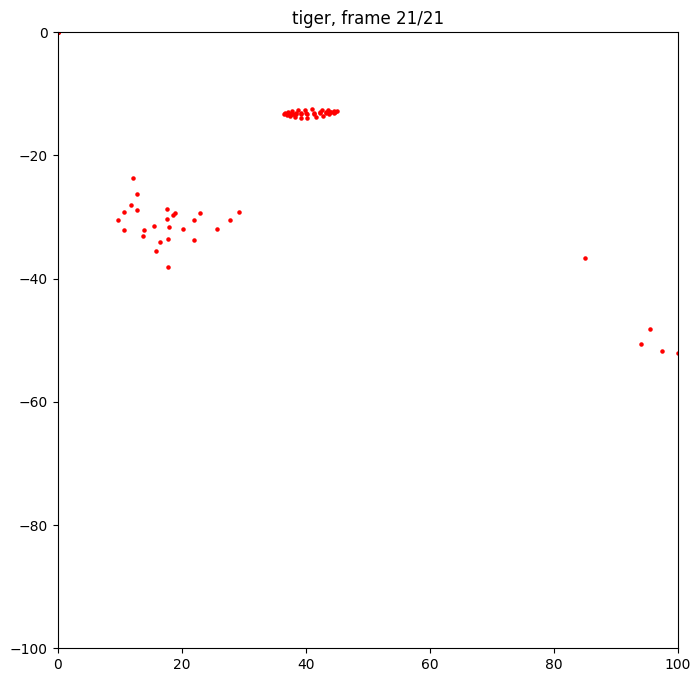

In [73]:
from IPython.display import display, clear_output, update_display
import time

file_path = worst_class_path[7]
pq_path = os.path.join(COMPETITION_PATH,file_path)
vv = get_data(pq_path)
print(f'number of frames: {len(vv)}')

fig = plt.figure(figsize=(8,8))

hfig = display(fig, display_id=True)

T = 3

def update():
    for i in range(len(vv)):

        plt.clf()
        plt.xlim(0,100)
        plt.ylim(-100,0)
        plt.scatter(100*vv[i,:,0],-100*vv[i,:,1], s=5, c='r')
        plt.title(f'{best_sign}, frame {i+1}/{len(vv)}')
        hfig.update(fig)
        print()
        time.sleep(T/len(vv))
    

update()
plt.close(fig)

number of frames: 31 and 28


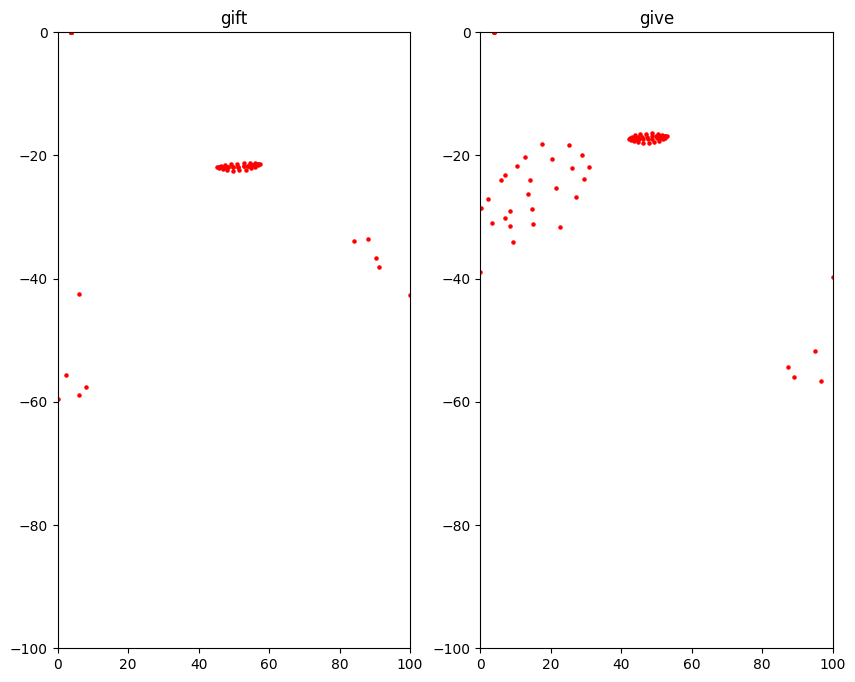

In [74]:
class_idx = worst_classes[0]
number_of_pred, pred_classes = torch.topk(confusion_matrix[int(class_idx)], 2)

sign1 = get_word_from_key(pred_classes[0])
sign2 = get_word_from_key(pred_classes[1])

path1 = random.choice(train[train.sign == sign1].path.values)
seq1 = get_data(os.path.join(COMPETITION_PATH,path1))
seq_len=-100

path_it = iter(train[train.sign == sign2].path.values)
while np.abs(seq_len-len(seq1))>5:
    path2 = next(path_it)
    seq2 = get_data(os.path.join(COMPETITION_PATH,path2))
    seq_len=len(seq2)


seq2 = get_data(os.path.join(COMPETITION_PATH,path2))

print(f'number of frames: {len(seq1)} and {len(seq2)}')

fig = plt.figure(figsize=(10,8))

hfig = display(fig, display_id=True)

T = 3
N = min(len(seq1),len(seq2))

def update():
    for i in range(N):
        plt.clf()
        
        plt.subplot(1,2,1)
        plt.xlim(0,100)
        plt.ylim(-100,0)
        plt.scatter(100*seq1[i,:,0],-100*seq1[i,:,1], s=5, c='r')
        plt.title(sign1)
        
        plt.subplot(1,2,2)
        plt.xlim(0,100)
        plt.ylim(-100,0)
        plt.scatter(100*seq2[i,:,0],-100*seq2[i,:,1], s=5, c='r')
        plt.title(sign2)
        
        hfig.update(fig)
        time.sleep(T/N)
    

update()
plt.close(fig)

In [75]:

#     """
#     Computes the Dynamic Time Warping distance between two sequences.
    
#     Parameters:
#     sequence1 (numpy.ndarray): First sequence with shape [n_frames1, n_landmarks, 2].
#     sequence2 (numpy.ndarray): Second sequence with shape [n_frames2, n_landmarks, 2].
    
#     Returns:
#     float: DTW distance between the two sequences.
#     """


file_path1 = best_class_path[5]
pq_path1 = os.path.join(COMPETITION_PATH,file_path1)
sequence1 = get_data(pq_path1)
print(len(sequence1))

file_path2 = worst_class_path[2]
pq_path2 = os.path.join(COMPETITION_PATH,file_path2)
sequence2 = get_data(pq_path2)
print(len(sequence2))

n_frames1 = len(sequence1)
n_frames2 = len(sequence2)

n_landmarks1 = len(sequence1[0])
n_landmarks2 = len(sequence2[0])

if n_landmarks1 != n_landmarks2:
    raise ValueError("The two sequences must have the same number of landmarks.")

# Initialize the cost matrix with infinity
cost = np.full((n_frames1 + 1, n_frames2 + 1), np.inf)
cost[0, 0] = 0

# Fill the cost matrix
for i in range(1, n_frames1 + 1):
    for j in range(1, n_frames2 + 1):
        dist = np.linalg.norm(sequence1[i-1] - sequence2[j-1])
        cost[i, j] = dist + min(cost[i-1, j], cost[i, j-1], cost[i-1, j-1])

# The DTW distance is the cost in the bottom-right corner of the matrix
dtw_distance = cost[n_frames1, n_frames2]/(n_frames1+n_frames2)

16
55


In [76]:
dtw_distance

0.651488277146604